In [105]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

# DC Motor simulation
## Parameters
### Motor
[Maxon DCX 22 EB KL 12V](https://www.maxongroup.com/medias/sys_master/root/8881021878302/EN-21-101.pdf)
11/20 W, 29.8 mNm, 7160 rpm

In [106]:
Maxon_RotorInertia = 9.0 # gcm2
Maxon_SpeedConstant = 416 # rpm/V
Maxon_TorqueConstant = 22.9 # mNm/A
Maxon_TerminalResistance = 1.84 # Ohms
Maxon_TerminalInductance = 0.198 # mH

Maxon_NominalCurrent = 1.3 # A
Maxon_NominalTorque = 29.5 # mMm
Maxon_StallCurrent = 6.54 # A

Maxon_MechanicalTimeConstant = 3.14e-3 # s

Added Toroidal Inductance to limit dc motor iron losses

In [107]:
Seabot_AddedInductance = 1.619e-3 # H
Seabot_AddedInductanceResistance = 480e-3 # Ohms

Parameters of the DC model

In [108]:
J = Maxon_RotorInertia * 1e-7 # Moment of inertia (kg.m^2)
# b/J = 1/Tau where Tau = Maxon_MechanicalTimeConstant
b = J/Maxon_MechanicalTimeConstant # Motor viscous friction constant (N.m.s) [ToDo : not directly given]
Ke = 1./(Maxon_SpeedConstant*2.*np.pi/60.) # Electromotive force constant  (V/rad/sec)
Kt = Maxon_TorqueConstant*1e-3 # Motor torque constant (N.m/Amp)
R = Maxon_TerminalResistance + Seabot_AddedInductanceResistance # Electric resistance (Ohm)
L = Maxon_TerminalInductance*1e-3 + Seabot_AddedInductance # Electric inductance (H)

### Reductor
[GPX22UP 103:1](https://www.maxongroup.com/medias/sys_master/root/8882582683678/EN-21-352.pdf)
3 stages

In [109]:
Maxon_Reduction = 103 # 103:1
Maxon_MaxContinuousTorque = 4.3 # Nm
Maxon_MassInertia = 0.6 # gcm2

### Endless Screw System

In [110]:
Screw_Thread = 1e-3 # m
Screw_Radius = 6e-3 # m
Screw_FrictionCoefficient = 0.2 # To be correctly evaluated ! Copper-Copper = 1.2
Piston_diam = 45e-3 # m 

### Environement

In [111]:
rho = 1025 # kg/m3
g = 9.81 # m/s-3
z_max = 100 # m

## First validation
* Compute the torque at requiered at 100m

In [112]:
pistonSurface = np.pi*(Piston_diam/2.)**2
force100 = pistonSurface*rho*g*z_max
print('Force at 100 m = {:.2f} N'.format(force100))

i_screw=Screw_Thread/(2*Screw_Radius) # Note : error in the thesis formula : diam and not radius
torque100 = force100*Screw_Radius*np.tan(Screw_FrictionCoefficient+i_screw)
print('Torque at 100 m = {:.2f} Nm'.format(torque100))

weight100 = force100/g
print('Equivalent in kg for test at 100m : {:.2f} kg'.format(weight100))
print('Equivalent in kg for test at 100m : {:.2f} kg'.format(weight100))

Force at 100 m = 1599.22 N
Torque at 100 m = 2.79 Nm
Equivalent in kg for test at 100m : 163.02 kg
Equivalent in kg for test at 100m : 163.02 kg


* Maximum torque at the output of the moto-reductor

In [113]:
max_torque_maxon = Maxon_NominalTorque*1.e-3*Maxon_Reduction
print('Max Torque = {:.2f} Nm'.format(max_torque_maxon))

Max Torque = 3.04 Nm


## Simulation


In [114]:
A = np.array([[-b/J, Kt/J], [-Ke/L,-R/L]])
B = np.array([0., 1./L])
W = np.array([-1/J, 0.0])
print(A)
print(B)

[[-3.18471338e+02  2.54444444e+04]
 [-1.26334837e+01 -1.27682994e+03]]
[  0.         550.35773253]


State space : x = [dtheta, i]

Input : u = [V] 

In [115]:
x = np.array([0., 0.])
u = 12 # V
torque = torque100/Maxon_Reduction
torque_non_revers = torque
dt = 1e-5
tmax = 0.1
result_x = np.array((0, x[0], x[1]))
for t in np.arange(dt, tmax, dt):
    if((Kt*x[1]-torque)<0):
        torque_non_revers = Kt*x[1]
    else:
        torque_non_revers = torque
    dx=A @ x + B*u + W*torque_non_revers
    x+=dx*dt
    
    result_x = np.vstack([result_x, np.array((t, x[0], x[1]))])
    

i_max = 4.317 A


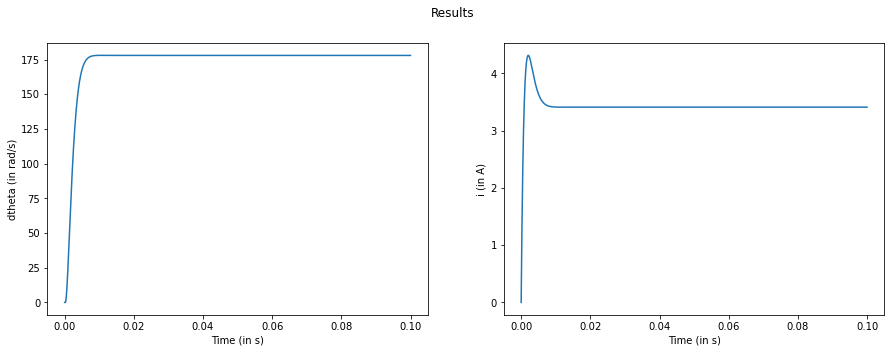

In [116]:
# Display
fig, axs = plt.subplots(1,2)
fig.suptitle('Results')
axs[0].plot(np.transpose(result_x)[0], np.transpose(result_x)[1])
axs[0].set_xlabel('Time (in s)')
axs[0].set_ylabel('dtheta (in rad/s)')

axs[1].plot(np.transpose(result_x)[0], np.transpose(result_x)[2])
axs[1].set_xlabel('Time (in s)')
axs[1].set_ylabel('i (in A)')

# Analysis
print('i_max = {:.3f} A'.format(np.max(np.transpose(result_x)[2])))